In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uproot
%matplotlib inline

In [2]:
train = int(1e4)
test = int(1e4)

In [3]:
file = uproot.open("../../data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root")
tree = file['tree']


In [4]:
T=tree
allstring=''
keys=[]
for key in T.keys():
    if 'mass' not in str(key)[2:-1] and 'massErr' not in str(key)[2:-1]:
        keys.append(str(key)[2:-1])
        allstring+=' '+str(key)[2:-1]
allstring=allstring[1:]
keys=keys[1:51]
no_true=[]
no_true_split=''
for key in keys:
    if 'true' not in key:
        no_true.append(key)
        no_true_split+=' '+key
no_true_split=no_true_split[1:]

In [5]:
cat="v0_rxy v0_chi2 cosTheta v0_rxyErr pT ntrk_pv0 a0 calpha a0xy pv0_y trueKs"
df = tree.pandas.df(cat.split(" "),\
                    entrystop = train + test)
df_all = tree.pandas.df(keys,entrystop = train+ test)

In [6]:
# Normalize data
df_norm = pd.DataFrame(None)
for col in df.columns[:-1]:
    df_norm[col] = (df[col] - df[col].mean()) / df[col].std()

# Seperate truth label
df_label = df.trueKs
    
scalers = {}
    
# Repeat for more data    
df_all_norm = pd.DataFrame(None)
for col in df_all.columns[:51]:
    if df_all[col].std() != 0:
        df_all_norm[col] = (df_all[col] - df_all[col].mean()) / df_all[col].std()
        scalers[col] = [df_all[col].mean(), df_all[col].std()]

In [7]:
len(df_all.columns)

50

In [8]:
df_test=df.sample(frac=0.5)
df_train=df.loc[~df.index.isin(df_test.index)]

In [9]:
# test logit
def logit(p):
    return np.log(p/(1-p))

AUC-scores are: v0_rxy: 0.706, v0_chi2: 0.747, cosTheta: 0.950, v0_rxyErr: 0.851, pT: 0.653, ntrk_pv0: 0.620, a0: 0.907, calpha: 0.506, a0xy: 0.886, pv0_y: 0.517


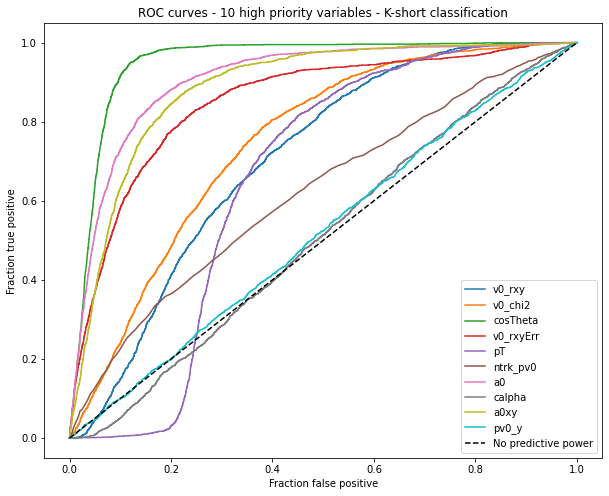

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score

fig, ax = plt.subplots(figsize = (10, 8))

ax.set(title = "ROC curves - 10 high priority variables - K-short classification", xlabel='Fraction false positive', ylabel='Fraction true positive')
aucs = {} # for recording auc_scores


for col in df_norm:
    auc = roc_auc_score(df_label, df_norm[col])
    if auc < .5:
        auc = 1 - auc
        scores = - df_norm[col]
    else:
        scores = df_norm[col]
    
    aucs[col] = auc
    
    x, y, c = roc_curve(df_label, scores)
    
    
    
    ax.plot(x, y, label = col)
    
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), 'k--', label='No predictive power')
ax.legend(loc = "lower right")
print("AUC-scores are: " + ", ".join([f"{name}: {aucs[name]:.3f}" for name in aucs.keys()]))

In [11]:
#Make xGboost work

#rough outlier

# Find outliers rought. Through five sigma away
z = (df - df.mean()) / df.std()
throw = z > 5
keep = throw.sum(axis = 1).apply(lambda x: x == 0)

df = df.loc[keep, :].reset_index(drop = True)
df.describe()

,v0_rxy,v0_chi2,cosTheta,v0_rxyErr,pT,ntrk_pv0,a0,calpha,a0xy,pv0_y,trueKs
count,19588.000000,1.958800e+04,19588.000000,19588.000000,19588.000000,19588.000000,19588.000000,19588.000000,19588.000000,19588.000000,19588.000000
mean,18.950218,3.678092e+00,0.172630,2.126675,154.563644,57.356187,6.104486,0.633712,2.941055,-0.000946,0.095160
std,44.871658,4.045900e+00,0.831615,3.962401,65.433624,27.124022,12.197728,0.461228,4.507347,0.065730,0.293444
min,0.033936,7.160586e-10,-1.000000,0.016833,0.798670,0.000000,0.000000,-0.999911,0.000000,-0.239051,0.000000
25%,2.502209,4.058133e-01,-0.818971,0.477361,109.135956,37.000000,0.839633,0.477371,0.418340,-0.044956,0.000000
50%,5.981484,2.024766e+00,0.544435,0.947925,157.044350,56.000000,2.679123,0.840339,1.486737,-0.000872,0.000000
75%,12.530687,5.808969e+00,0.985312,1.977369,202.650688,75.000000,6.074095,0.958368,3.820057,0.041067,0.000000
max,441.191742,1.513414e+01,1.000000,42.514828,293.256073,158.000000,124.313393,0.999998,61.123257,0.216634,1.000000


In [12]:
from xgboost import XGBClassifier
import shap
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier

In [13]:
# setup train and test data, consider random sampling
train_X = df_all_norm.iloc[:train, :]
train_Y = df_label[:train]
test_X = df_all_norm.iloc[train:, :]
test_Y = df_label[train:]

LightGBM classifier has auc: 0.993
Accuracy: 98.89% for LightGBM


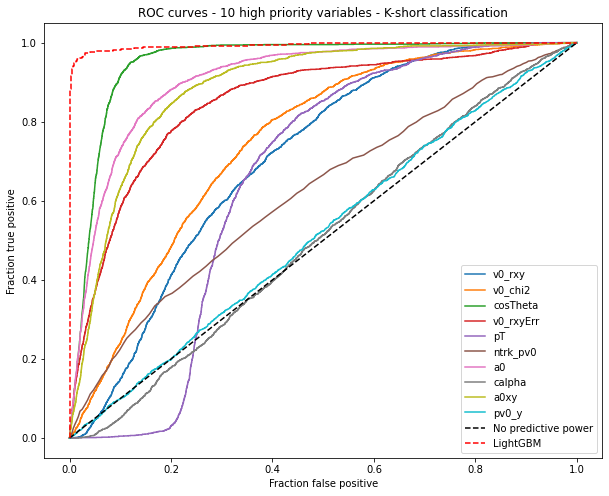

In [14]:
model = LGBMClassifier().fit(train_X, train_Y)
# model = LGBMClassifier(max_depth=32, learning_rate=0.01).fit(train_X, train_Y) #this is worse
score = model.predict_proba(test_X)
plot=1
if plot==1:
    auc = roc_auc_score(test_Y, score[:, 1])
    aucs['lgb'] = auc

    print(f"LightGBM classifier has auc: {auc:.3f}")

    x, y, _ = roc_curve(test_Y, score[:, 1])

    ax.plot(x, y, 'r--', label = "LightGBM")
    ax.legend(loc = "lower right")
accuracy = accuracy_score(test_Y, [round(value) for value in score[:,1]])
print("Accuracy: {:.2f}% for LightGBM".format(accuracy * 100.0))
fig

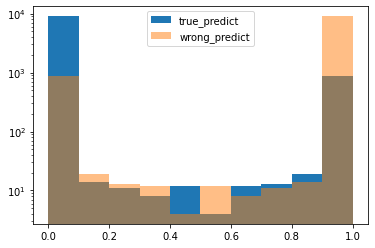

In [15]:
plt.hist(score[:,1], label='true_predict')
plt.hist(score[:,0], alpha=0.5, label='wrong_predict')
plt.yscale('log')
plt.legend()

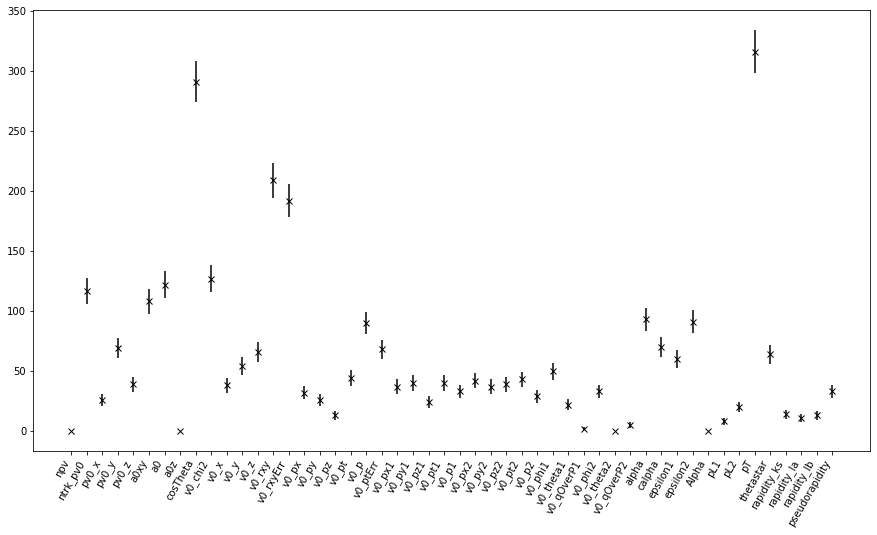

In [16]:
imp=model.feature_importances_
fig1, ax1=plt.subplots(figsize=(15,9))
ax1.errorbar(range(len(imp)), imp, yerr=np.sqrt(imp), fmt='kx')
ax1.set(xticks=range(len(imp)), xticklabels=keys)
fig1.autofmt_xdate(rotation=60)

In [17]:
most_important = [x for _,x in sorted(zip(imp,keys))]
most_important_lgbm=most_important[::-1][:10]
johann=cat.split(" ")[:-1]
print('The following top10 features disagree between shap from xgboost and here')
for i in most_important_lgbm:
    if i not in johann:
        print(i)

The following top10 features disagree between shap from xgboost and here
alpha
epsilon2


In [18]:
# Train xgboost
modelxg = XGBClassifier().fit(train_X, train_Y)

XGBoost classifier has auc: 0.951


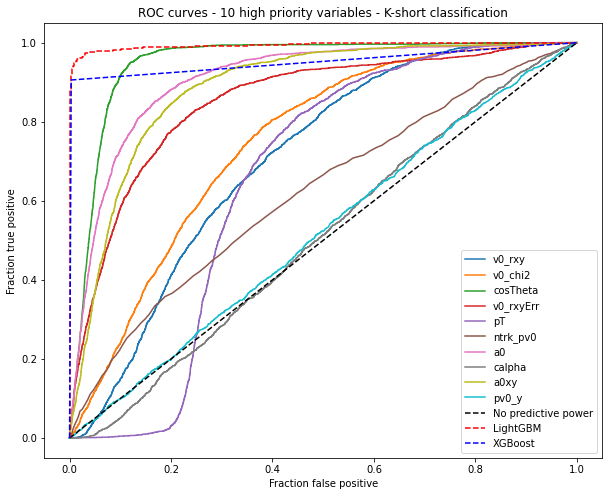

In [19]:
y_pred = modelxg.predict(test_X)
plot=1
if plot==1:
    auc = roc_auc_score(test_Y, y_pred)
    aucs['xgb'] = auc

    print(f"XGBoost classifier has auc: {auc:.3f}")

    x, y, _ = roc_curve(test_Y, y_pred)

    ax.plot(x, y, 'b--', label = "XGBoost")
    ax.legend(loc = "lower right")
fig

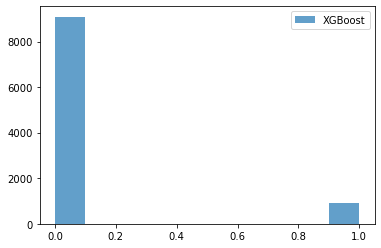

In [20]:
predictions = [round(value) for value in y_pred]
plt.hist(y_pred, alpha=0.7, label='XGBoost')
plt.legend()

In [21]:
accuracy = accuracy_score(test_Y, predictions)
print("Accuracy: {:.2f}% for XGBoost".format(accuracy * 100.0))

Accuracy: 98.79% for XGBoost


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


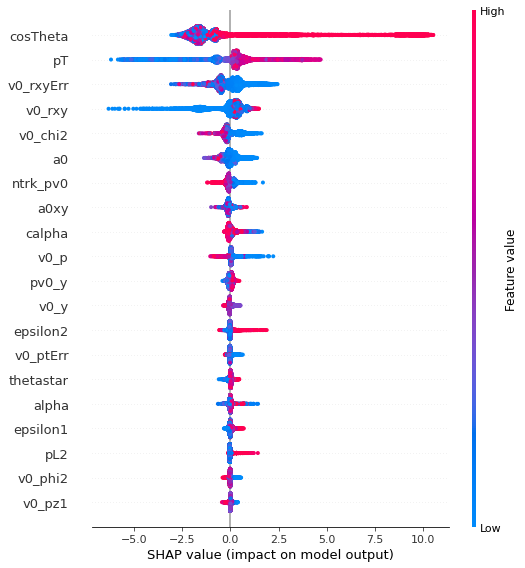

In [22]:
Explainer=shap.TreeExplainer(model)
shap_values = Explainer.shap_values(test_X)
shap.summary_plot(shap_values[1], test_X, plot_type='dot') 
#the index of shap values gives the things that correlate with either predicting 1 or 0

In [23]:
len(shap_values), len(shap_values[0])

(2, 10000)

In [24]:
keep_feature_amount = 15
features = test_X.columns[np.argsort(abs(shap_values[0]).mean(0))[::-1]][:keep_feature_amount]
features = list(features)

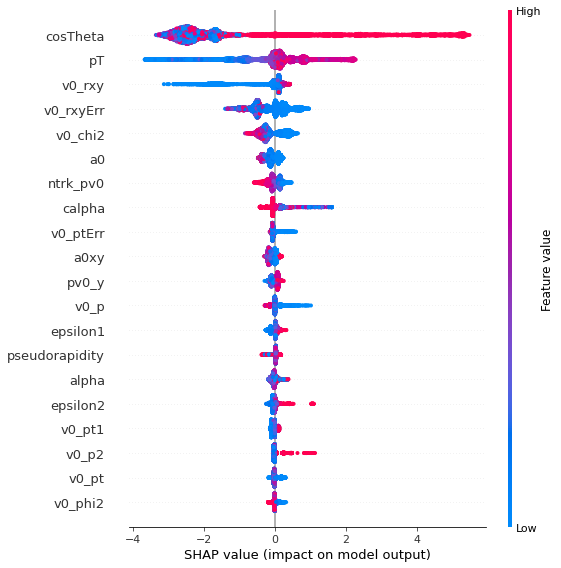

In [27]:
Explainer=shap.TreeExplainer(modelxg)
shap_values = Explainer.shap_values(test_X)
shap.summary_plot(shap_values, test_X)

In [34]:
import dill

def predict_xgboost(df):
    """ Model for XGBoost trained in MC 
    Must be given the full parameter set (50) to work on, without true and without mass
    npv ntrk_pv0 pv0_x pv0_y pv0_z a0xy a0 a0z cosTheta v0_chi2 v0_x v0_y v0_z v0_rxy v0_rxyErr v0_px v0_py v0_pz v0_pt v0_p v0_ptErr v0_px1 v0_py1 v0_pz1 v0_pt1 v0_p1 v0_px2 v0_py2 v0_pz2 v0_pt2 v0_p2 v0_phi1 v0_theta1 v0_qOverP1 v0_phi2 v0_theta2 v0_qOverP2 alpha calpha epsilon1 epsilon2 Alpha pL1 pL2 pT thetastar rapidity_ks rapidity_la rapidity_lb pseudorapidity
    """
    df_all_norm = pd.DataFrame(None)
    for col in df.columns:
        if df[col].std() != 0:
            df_all_norm[col] = (df[col] - df[col].mean()) / df[col].std()
    labels = model.predict(df_all_norm)
    return labels

seri = dill.dumps(predict_xgboost, recurse = True)

file = open("models/MC_trained_xgboost_full.dat", 'wb')
dill.dump(seri, file)
file.close()


seri = dill.dumps(model, recurse = True)

file = open('models/MC_trained_xgboost.dat', 'wb')
dill.dump(seri, file)
file.close()

In [33]:
help(predict_xgboost)

Help on function predict_xgboost in module __main__:

predict_xgboost(df)
    Must be given the full parameter set (50) to work on, without true and without mass
    npv ntrk_pv0 pv0_x pv0_y pv0_z a0xy a0 a0z cosTheta v0_chi2 v0_x v0_y v0_z v0_rxy v0_rxyErr v0_px v0_py v0_pz v0_pt v0_p v0_ptErr v0_px1 v0_py1 v0_pz1 v0_pt1 v0_p1 v0_px2 v0_py2 v0_pz2 v0_pt2 v0_p2 v0_phi1 v0_theta1 v0_qOverP1 v0_phi2 v0_theta2 v0_qOverP2 alpha calpha epsilon1 epsilon2 Alpha pL1 pL2 pT thetastar rapidity_ks rapidity_la rapidity_lb pseudorapidity

